# Cost-Sensitive Multi-Class Classification
** *

This IPython notebook illustrates the usage of the [costsensitive](http://www.github.com/david-cortes/costsensitive) Python pacakge for cost-sensitive multi-class classification through an applied example using the [Covertype Data Set](https://archive.ics.uci.edu/ml/datasets/covertype) - a public dataset for multi-class classification - converted into cost-sensitive classification by assigning to it different costs for different types of classification errors and features of each observation.

** Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/costsensitive/blob/master/example/costsensitive_multiclass_classification.ipynb). **

** *
### Sections
[1. Problem description](#p1)

[2. The data set](#p2)

[3. Different costs for different types of errors](#p3)

[4. Fitting cost-sensitive classifiers](#p4)

[5. Results side by side](#p5)

[6. References](#p6)

** *
<a id="p1"></a>
## 1. Problem description

Cost-sensitive multi-class classification is a problem related to multi-class classification, in which instead of there being one or more "correct" labels for each observation, there is an associated vector of costs for labeling each observation under each label, and the goal is to build a classifier that predicts the class with the minimum expected cost. 

It is a more general problem that classification with costs defined for its confusion matrix (i.e. specifying how costly it is for each label to predict each other different label) or multi-class classification with observation weights (i.e. misclassifying each observation has a different cost, but this cost is the same regardless of the true and the predicted class), as here each observation can have a different cost for each type of misprediction. 

When the costs are in the form of $C = \{\textbf{1}I(f(x) = y)\}$ (that is, the cost for predicting the right labels is zero, while the cost for predicting a wrong label is one), the problem is equivalent to maximizing multiclass classification accuracy. 

The aim of the algorithms here is to reduce this problem to binary classification with sample weights, which is a more well-studied problem for which many good algorithms are available. A further reduction to binary classification without sample weights is possible through the costing-proportionate rejection-sampling method, also implemented here (see [Section 3](#p3)).

The problem requires the following data:
* A feature matrix of size $(n\_{observations}, n\_{features})$ with the covariates or features of each observation.
* A cost matrix of size $(n\_observations, n\_classes)$ **with non-negative numbers** specifying how much would it **cost** to choose each class/label for each observation (meaning: **the higher, the worse**).

** *
<a id="p2"></a>
## 2. The data set

The example here will use the Covertype dataset from UCI, which contains data about forest cover types (7 different classes) for patches of land in a forest, and attributes about it such as the distance to some landmarks, shade, elevation, etc.

The dataset - along with more information about it - is available in the UCI webpage:
[https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype)

Description taken from the link above:
> **Data Set Information:**
> 
> Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). 
> 
> This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. 
> 
> Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value. 
> 
> As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4). 
> 
> The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.


> **Attribute Information:**
> 
> Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database. 
> 
> Name / Data Type / Measurement / Description 
> 
> * Elevation / quantitative /meters / Elevation in meters
> * Aspect / quantitative / azimuth / Aspect in degrees azimuth
> * Slope / quantitative / degrees / Slope in degrees
> * Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features 
> * Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
> * Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
> * Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
> * Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
> * Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
> * Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
> * Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
> * Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
> * Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

***
Loading the data:

In [1]:
import pandas as pd, numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

cov_type=pd.read_csv('covtype.data',header=None)
cov_type=cov_type.as_matrix()
X=(cov_type[:,:cov_type.shape[1]-1]).astype('float64')
y=cov_type[:,cov_type.shape[1]-1]-1

ml=MultiLabelBinarizer()
y_onehot=ml.fit_transform(y.reshape(-1,1))
print(X.shape)
print(y.shape)
print(y_onehot.shape)

(581012, 54)
(581012,)
(581012, 7)


** *
<a id="p3"></a>
## 3. Different costs for different types of errors

This dataset is meant to benchmark classifiers that aim to minimize classification error. However, the goal in cost-sensitive classification is not to minimize classification error, but rather some measure of cost in which each choice of label or class for each observation is associated with its own cost.

In order to conver the problem into cost-sensitive classification, I will:
* Create an  error-cost matrix by assign different costs for each error type in the confusion matrix.
* Amplify or shrink all the costs for an observation according to the values of some of its attributes.

** *
Creating an arbitrary error-cost matrix - the entries at each cell $({row}_{a}, {column}_{b})$  specify how costly it should be to predict class $a$ when the true class is $b$:

In [2]:
import pandas as pd, numpy as np

n_classes=y_onehot.shape[1]

missclassif_cost_matrix=np.zeros((n_classes,n_classes))
np.random.seed(1)
for i in range(n_classes-1):
    for j in range(i+1,n_classes):
        cost_missclassif=np.random.gamma(1,5)
        missclassif_cost_matrix[i,j]=cost_missclassif
        missclassif_cost_matrix[j,i]=cost_missclassif
        
pd.DataFrame(missclassif_cost_matrix)

,0,1,2,3,4,5,6
0,0.000000,2.698029,6.370626,0.000572,1.800064,0.793548,0.484419
1,2.698029,0.000000,1.030573,2.119882,2.527263,3.869799,2.716697
2,6.370626,1.030573,0.000000,5.779399,1.143622,10.523486,0.138848
3,0.000572,2.119882,5.779399,0.000000,5.550402,2.700455,4.090037
4,1.800064,2.527263,1.143622,5.550402,0.000000,0.756365,1.103866
5,0.793548,3.869799,10.523486,2.700455,0.756365,0.000000,8.065839
6,0.484419,2.716697,0.138848,4.090037,1.103866,8.065839,0.000000


From this, we can now define the cost matrix for each example to be the row of the error-cost matrix above corresponding to the class of each observation in the original dataset:

In [3]:
C=np.array([missclassif_cost_matrix[i] for i in y])

The weights can be altered furthered according to features of the observations - meaning that it's more important to predict correctly (or less costly) for some types of observations than for others:

In [4]:
C=C*(X[:,9]/2000).reshape(-1,1)
C=C/(1+X[:,22]*20).reshape(-1,1)
C=C/(1+X[:,30]*7).reshape(-1,1)
C=C*(1+X[:,41]*3).reshape(-1,1)
C=C*(1+X[:,47]*8).reshape(-1,1)

pd.DataFrame(C).head()

,0,1,2,3,4,5,6
0,5.651300,7.934341,3.590401,17.425486,0.000000,2.374607,3.465588
1,5.602698,7.866105,3.559524,17.275625,0.000000,2.354185,3.435783
2,8.257318,0.000000,3.154069,6.487900,7.734688,11.843519,8.314451
3,8.378730,0.000000,3.200445,6.583295,7.848414,12.017660,8.436702
4,5.554997,7.799133,3.529218,17.128539,0.000000,2.334141,3.406531


** *
<a id="p4"></a>
## 4. Fitting cost-sensitive classifiers

The algorithms implemented here are reduction methods that turn the problem into a series of importance-weighted binary classification sub-problems - for details see the papers in the [references section](#p6).

Here the examples will all use **Logistic Regression** from scikit-learn as the base classifier for the subproblems, except for regression-based One-Vs-Rest which will use Linear Regression with L2 regularization (a.k.a. Ridge). The algorithms will nevertheless work with any other classifier having a scikit-learn-like API (not necessarily scikit-learn-compatible) and supporting sample weights, such as xgboost. The requirements for a classifier to work here are:
* A fit method of the form `classifier.fit(X, y, sample_weights=w)`.
* A predict method of the form `classifier.predict(X)`.
* (Optionally) for some functionality and some methods, a `classifier.predict_proba(X)` method.
* For `RegressionOneVsRest`, an object with `fit` and `predict` that would perform regression rather than classification.

(Where `X`, `y`, and `w` are numpy arrays.)

The main idea behind them is to compare the predictions of different classifiers comparing one or more classes against another or several other classes, with each subproblem getting observation weights that would make the final result efficient or optimal in some way in relationship to the subproblems' error or regret.

Note that the implementations here are all 'multi oracle call' rather than 'single oracle' - that is, they construct a series of subproblems instead of a single classification problem where the indices of the classes being compared are additional features. These tend to work with a broader class of classifiers and to provide more consistent results across tasks.

The package also contains some simple heurstics that don't enjoy theoretical bounds on their regret but which can do very well in practice, such as One-Vs-Rest setting the weights to be the absolute difference between the costs of the  class compared against and the minimum cost of any other class (perhaps the most obvious algorithm that one would try for this problem), or All-Pairs with the sample weights being the absolute difference in cost between each two classes.

Note that One-Vs-Rest classification implies solving one classification subproblem per class, while All-Pairs implies solving $\frac{m(m-1)}{2}$ subproblems (where $m$ is the number of classes), so it doesn't scale well to problems with many classes.

All the algorithms here contain a `fit` and a `predict` method, with some having an additional `decision_function`. They are all documented internally through docstrings (e.g. you can try `help(WeightedAllPairs)`, `help(WeightedAllPairs.fit)`, `help(WeightedAllPairs.predict)`, `help(WeightedAllPairs.decision_function`, etc.).
***
Generating a train-test split and standardizing the data:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, C_train, C_test, y_train, y_test = train_test_split(X, C, y, test_size=.5, random_state=1)
scaler=StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Fitting the classifiers and tracking test set results:

In [6]:
from costsensitive import WeightedAllPairs, WeightedOneVsRest, RegressionOneVsRest, \
                            FilterTree, CostProportionateClassifier
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression, Ridge

### Keeping track of the results for later
name_algorithm=list()
test_accuracy=list()
test_cost=list()

################ Note ################
### These reduction methods require classifiers supporting sample weights.
### If your favorite classifier doesn't, you can convert it to
### an importance-weighted classifier like this:
ClassifierSupportingSampleWeights = CostProportionateClassifier(LogisticRegression())
### (replace LogistRegression for your classifier)

#### Benchmark : Logistic Regression with no weights
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)
name_algorithm.append("Multinomial Loss")
test_accuracy.append(np.mean(preds_lr==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_lr].sum())

In [7]:
#### 1. Weighted All-Pairs as described in "Error limiting reductions between classification tasks."
costsensitive_WAP = WeightedAllPairs(LogisticRegression(solver='lbfgs'), weigh_by_cost_diff=False)
costsensitive_WAP.fit(X_train, C_train)
preds_WAP = costsensitive_WAP.predict(X_test, method='most-wins')
name_algorithm.append("Weighted All-Pairs (original)")
test_accuracy.append(np.mean(preds_WAP==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_WAP].sum())

In [8]:
#### 2. Weighted All-Pairs - simpler cost-weighting schema
costsensitive_WAP2 = WeightedAllPairs(LogisticRegression(solver='lbfgs'), weigh_by_cost_diff=True)
costsensitive_WAP2.fit(X_train, C_train)
preds_WAP2 = costsensitive_WAP2.predict(X_test, method='most-wins')
name_algorithm.append("Weighted All-Pairs (Simple importance weights)")
test_accuracy.append(np.mean(preds_WAP2==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_WAP2].sum())

In [9]:
#### 3. Weighted All-Pairs with weighted vote
costsensitive_WAP3 = WeightedAllPairs(LogisticRegression(solver='lbfgs'), weigh_by_cost_diff=False)
costsensitive_WAP3.fit(X_train, C_train)
preds_WAP3 = costsensitive_WAP3.predict(X_test, method='goodness')
name_algorithm.append("Weighted All-Pairs (Weighted Vote)")
test_accuracy.append(np.mean(preds_WAP3==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_WAP3].sum())

In [10]:
#### 4. Weighted All-Pairs with weighted vote and simpler cost-weighting schema
costsensitive_WAP4 = WeightedAllPairs(LogisticRegression(solver='lbfgs'), weigh_by_cost_diff=True)
costsensitive_WAP4.fit(X_train, C_train)
preds_WAP4 = costsensitive_WAP4.predict(X_test, method='goodness')
name_algorithm.append("Weighted All-Pairs (Weighted Vote, Simple imp. weights)")
test_accuracy.append(np.mean(preds_WAP4==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_WAP4].sum())

In [11]:
#### 5. One-Vs-Rest, simple cost-weighting schema
costsensitive_OVR_simple = WeightedOneVsRest(LogisticRegression(solver='lbfgs'), weight_simple_diff=True)
costsensitive_OVR_simple.fit(X_train, C_train)
preds_OVR_simple = costsensitive_OVR_simple.predict(X_test)
name_algorithm.append("Weighted One-Vs-Rest")
test_accuracy.append(np.mean(preds_OVR_simple==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_OVR_simple].sum())

In [12]:
#### 6. One-Vs-Rest, cost-weighting schema from WAP
costsensitive_OVR = WeightedOneVsRest(LogisticRegression(solver='lbfgs'), weight_simple_diff=False)
costsensitive_OVR.fit(X_train, C_train)
preds_OVR = costsensitive_OVR.predict(X_test)
name_algorithm.append("Weighted One-Vs-Rest (WAP weighting technique)")
test_accuracy.append(np.mean(preds_OVR==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_OVR].sum())

In [13]:
#### 7. One-Vs-Rest, regression variant
costsensitive_ROVR = RegressionOneVsRest(Ridge(1))
costsensitive_ROVR.fit(X_train, C_train)
preds_ROVR = costsensitive_ROVR.predict(X_test)
name_algorithm.append("Regression One-Vs-Rest")
test_accuracy.append(np.mean(preds_ROVR==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_ROVR].sum())

In [14]:
#### 8. Filter-Tree
costsensitive_FT = FilterTree(LogisticRegression(solver='lbfgs'))
costsensitive_FT.fit(X_train, C_train)
preds_FT = costsensitive_FT.predict(X_test)
name_algorithm.append("Filter-Tree")
test_accuracy.append(np.mean(preds_FT==y_test))
test_cost.append(C_test[np.arange(C_test.shape[0]), preds_FT].sum())

** *
<a id="p5"></a>
## 5. Results side by side

In [15]:
import pandas as pd

results = pd.DataFrame({
    'Method' : name_algorithm,
    'Accuracy' : test_accuracy,
    'Total Cost' : test_cost
})
results=results[['Method', 'Total Cost', 'Accuracy']]
results.set_index('Method')

,Total Cost,Accuracy
Method,,
Multinomial Loss,207937.934777,0.725011
Weighted All-Pairs (original),223965.631301,0.520444
Weighted All-Pairs (Simple importance weights),186106.555995,0.461089
Weighted All-Pairs (Weighted Vote),190914.941553,0.493618
"Weighted All-Pairs (Weighted Vote, Simple imp. weights)",205443.837138,0.411923
Weighted One-Vs-Rest,319508.482779,0.527442
Weighted One-Vs-Rest (WAP weighting technique),327994.726305,0.531125
Regression One-Vs-Rest,203183.597215,0.475460
Filter-Tree,375833.578406,0.201662


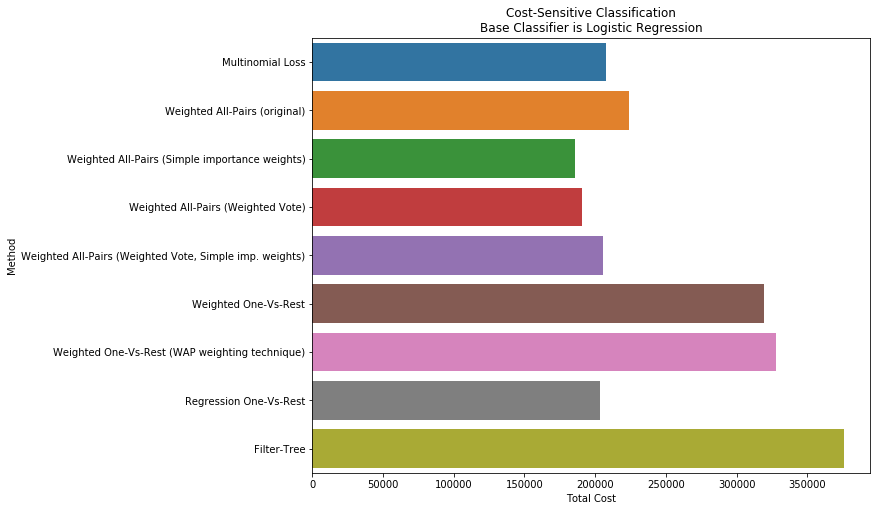

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.barplot(x="Total Cost", y="Method", data=results)
plt.title('Cost-Sensitive Classification\nBase Classifier is Logistic Regression')
plt.show()

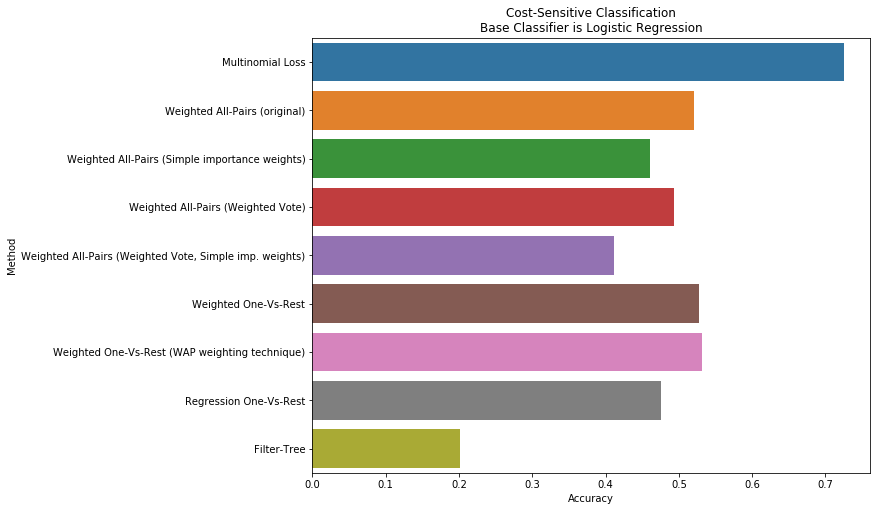

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.gcf()
fig.set_size_inches(10, 8)
sns.barplot(x="Accuracy", y="Method", data=results)
plt.title('Cost-Sensitive Classification\nBase Classifier is Logistic Regression')
plt.show()

** *
<a id="p6"></a>
## 6. References

* Beygelzimer, A., Dani, V., Hayes, T., Langford, J., & Zadrozny, B. (2005, August). Error limiting reductions between classification tasks. In Proceedings of the 22nd international conference on Machine learning (pp. 49-56). ACM.
* Beygelzimer, A., Langford, J., & Zadrozny, B. (2008). Machine learning techniques—reductions between prediction quality metrics. In Performance Modeling and Engineering (pp. 3-28). Springer US.
* Beygelzimer, A., Langford, J., & Ravikumar, P. (2007). Multiclass classification with filter trees. Preprint, June, 2.